In [3]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.preprocessing import text

import shap

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file = "/content/drive/My Drive/Colab Notebooks/sentence_data.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
full_data = pd.read_csv(file)

## Data Prep

In [0]:
candidates = ['Trump', 'Bernie', 'Sanders', 'Biden', 'Warren', 'Buttigieg', 'Bloomberg', 'Klobuchar', 'Yang', 'Steyer', 'Gabbard']

data = full_data.loc[full_data['candidates_mentioned'] == 1][['article_text']]
        
# add labels
data['label'] = data['article_text'].str.extract('({})'.format('|'.join(candidates)), 
                                                 flags = re.IGNORECASE, expand = False).str.lower().fillna('')
data['label'] = np.where(data['label'].str.contains('bernie'), 'sanders', data['label'])

# filter data set
data = data.loc[data['label'].isin(['biden', 'sanders'])]

# remove candidate names
data['article_text'] = data['article_text'].str.replace('Bernie', '[candidate]')
data['article_text'] = data['article_text'].str.replace('Bernard', '[candidate]')
data['article_text'] = data['article_text'].str.replace('Sanders', '[candidate]')
data['article_text'] = data['article_text'].str.replace('Joe', '[candidate]')
data['article_text'] = data['article_text'].str.replace('Joseph', '[candidate]')
data['article_text'] = data['article_text'].str.replace('Biden', '[candidate]')

data = data.drop_duplicates()

# label numeric
data['label'] = np.where(data['label'] == "sanders", 1, 0)

In [8]:
data.head()

,article_text,label
0,[candidate] [candidate]’ (I-VT) campaign stat...,1
1,” Khanna said that while a loss in Michigan wo...,1
32,Democrat voters must determine if [candidate] ...,0
33,[candidate]’s Super Tuesday performance — win...,0
34,[candidate] [candidate]’ (I-VT) 501 delegates...,1


In [0]:
def clean_text(data):
  """
  data: String series
  return: Clean series
  """
  sentences = data['article_text'].str.strip() # strip white space
  sentences = [sentences.lower() for sentences in sentences] # lowercase everything
  sentences = [re.sub('[0-9]','', s) for s in sentences] # remove numbers
  sentences = [re.sub(r'[^\w\s]','',s) for s in sentences] # remove punctuation
  
  # remove stopwords
  clean = [] 
  for item in sentences:
    for word in stopwords.words('english'):
        item = item.replace(" " + word + " ", ' ')
    clean.append(item)
    
  data['article_text'] = clean

  return data['article_text']

In [0]:
data['article_text'] = clean_text(data)

In [11]:
data.head()

,article_text,label
0,candidate candidate ivt campaign stated well m...,1
1,khanna said loss michigan wouldnt hurt ration...,1
32,democrat voters must determine candidate candi...,0
33,candidates super tuesday performance winning ...,0
34,candidate candidate ivt delegates result str...,1


In [0]:
# shuffle
np.random.seed(42)
data = data.sample(frac = 1)
data = data.reset_index(drop = True)

In [0]:
# small sample for training and reshuffle again
sample_data = data.groupby('label').apply(pd.DataFrame.sample, n = 5000, replace = True)
sample_data = sample_data.sample(frac = 1)
sample_data = sample_data.reset_index(drop = True)

In [0]:
list_corpus = sample_data['article_text'].tolist()
list_labels = sample_data['label'].tolist()

In [0]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, random_state = 42)      

In [0]:
VOCAB_SIZE = 500 

tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

bag_of_words_train = tokenizer.texts_to_matrix(X_train)
bag_of_words_test = tokenizer.texts_to_matrix(X_test)

array_labels_train = np.asarray(y_train).astype('float32').reshape((-1,1))
array_labels_test = np.asarray(y_test).astype('float32').reshape((-1,1))

Neural Network

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 26,351
Trainable params: 26,351
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(bag_of_words_train, array_labels_train, epochs=10, batch_size=128)

Epoch 1/10
59/59 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6259
Epoch 2/10
59/59 [==============================] - 0s 3ms/step - loss: 0.5613 - accuracy: 0.7272
Epoch 3/10
59/59 [==============================] - 0s 3ms/step - loss: 0.4780 - accuracy: 0.7657
Epoch 4/10
59/59 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8027
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 0.3793 - accuracy: 0.8323
Epoch 6/10
59/59 [==============================] - 0s 3ms/step - loss: 0.3315 - accuracy: 0.8615
Epoch 7/10
59/59 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.8847
Epoch 8/10
59/59 [==============================] - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9113
Epoch 9/10
59/59 [==============================] - 0s 3ms/step - loss: 0.1978 - accuracy: 0.9283
Epoch 10/10
59/59 [==============================] - 0s 3ms/step - loss: 0.1640 - accuracy: 0.9429


In [31]:
model.evaluate(bag_of_words_test, array_labels_test, batch_size=128)

20/20 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.8136


[0.4683728516101837, 0.8136000037193298]

In [32]:
from sklearn.metrics import classification_report
test_pred = model.predict(bag_of_words_test)
test_pred = (test_pred > 0.5)
print(classification_report(array_labels_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82      1264
         1.0       0.81      0.81      0.81      1236

    accuracy                           0.81      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.81      0.81      0.81      2500



SHAP

In [0]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, bag_of_words_train[:100])

# explain the first 10 predictions
shap_values = explainer.shap_values(bag_of_words_test)

In [0]:
# map BoW encoding back to original words
words = dict(tokenizer.word_index.items())

# Convert it to a list
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup

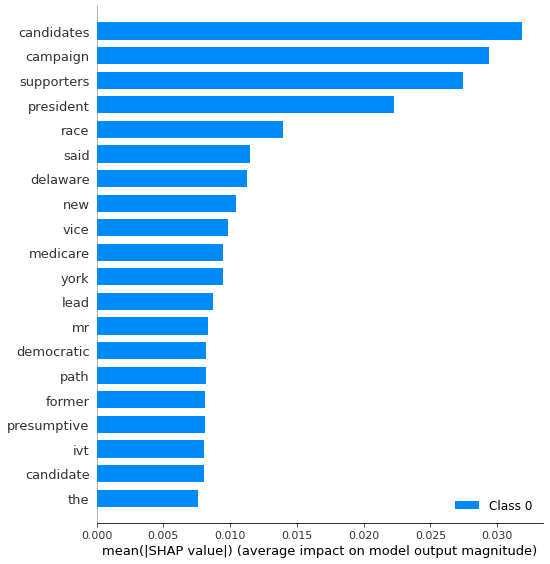

In [155]:
shap.summary_plot(shap_values, feature_names=word_lookup)

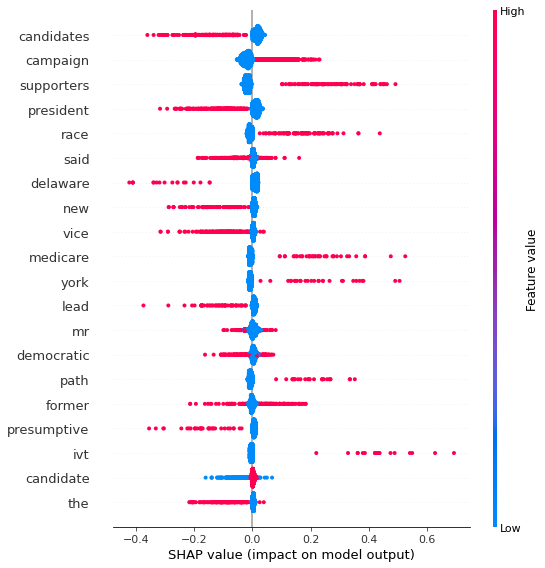

In [156]:
shap.summary_plot(shap_values[0], bag_of_words_test, feature_names=word_lookup)

In [157]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][1], bag_of_words_test[0:1], 
                feature_names=word_lookup[:500], link="logit")